In [9]:
### DATA ANALYSIS ###
import pandas as pd
import os
import numpy as np
import json
import re

In [10]:
### STATS ###
import statsmodels.stats.multitest as multi

In [11]:
### PLOTTING ###
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns

In [12]:
import sys
sys.path.append("/cellarold/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')

In [14]:
import myvariant
mv = myvariant.MyVariantInfo()

### results from script: run-plink-association.sh

##### Get index snps from association results with heritable immune phenotypes driven by nonHLA/KIR regions

Compiled values from plink clumping method. P1 threshold: .000000070922, P2 threshold: 0.00001, R2 threshold: 0.50, KB threshold: 250

In [15]:
def get_clumps(directory,snp_type):
    
    '''
    Input: directory with all plink .clumped files to be aggregated
    Output: dataframe with INDEX SNP, p-value, association paramter
    '''
    
    #get clumped files
    files=os.listdir(directory)
    file_lst=[x for x in files if ".clumped" in x]
    
    if snp_type == "index":
    
        #iterate through all clumped files and extract index snps
        snps=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                snps.append(row["SNP"])
                p.append(row["P"])
                assoc.append(x.split(".clump.clumped")[0])
    
        df_assoc=pd.DataFrame({"snps":snps,"file":assoc,"p-value":p})

    
    if snp_type == "all":
        snps=[]
        indexsnp=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                for y in row["SP2"].split("(1),"):
                    snps.append(y)
                    indexsnp.append(row["SNP"])
                    p.append(row["P"])
                    assoc.append(x.split(".clump.clumped")[0])
                
        df_assoc=pd.DataFrame({"indexsnps":indexsnp,"snps":snps,"file":assoc,"p-value":p})
        df_assoc=df_assoc[~(df_assoc["snps"]=="")]
        df_assoc=df_assoc[~(df_assoc["snps"]=="NONE")]
        df_assoc["snps"]=df_assoc["snps"].str.split("(").str[0]

    #add beta and p-value
    
    df_beta=pd.DataFrame()

    for x in [x for x in os.listdir(directory) if ".sig.assoc" in x]:
        try:
            df=pd.read_csv(directory+x,delimiter="\t",header=None)
            df.columns=["#CHROM", "POS", "snps","REF","ALT","A1","TEST","OBS_CT","beta","SE","T_STAT","P","ERRCODE"]
            df["file"]=x.split(".sig.assoc")[0]
            df_beta=df_beta.append(df)
        except:
            pass
    
    df_assoc=pd.merge(df_assoc,df_beta[["snps","file","beta","SE","A1"]],on=["file","snps"],how="left")
    return(df_assoc)
    

In [16]:
def map_rsid(x):
    
    '''
    Input: SNP format (chr:bp:minor:major or rsid)
    Output: tuple (variant,rsid)
    '''
    
    try:
        if "rs" in x:
            try:
                var=(re.findall('\d+',mv.getvariants(x)[0]["_id"]))[0]+":"+(re.findall('\d+',mv.getvariants(x)[0]["_id"]))[1]+":"+re.split("[^a-zA-Z]*",mv.getvariants(x)[0]["_id"])[-4]+":"+re.split("[^a-zA-Z]*",mv.getvariants(x)[0]["_id"])[-2]
                rs=x
            except:
                var=np.nan
                rs=x
        else:
            try:
                var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[2]+">"+x.split(":")[3]
                rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
            except:
                try:
                    var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
                    rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
                except:
                    var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
                    rs=np.nan
    except:
        var=np.nan
        rs=np.nan
        
    return (var,rs)
  

In [17]:
def extract(directory):
    
    '''
    Input: directory with conditional hla output
    Output: dataframe with conditional SNP, beta, p-value, effect allele, IP component
    '''
    df_hla_cond=pd.DataFrame()
    files=[x for x in os.listdir(directory) if "assoc" in x]
    files=[x for x in files if "plot" not in x]
    print(len(files))
    for x in files:
        df=pd.read_csv(directory+x,header=None,delimiter="\t")
        df["pheno"]=x.split(".assoc")[0]
        df["iteration"]=df.index
        df_hla_cond=df_hla_cond.append(df)
    df_hla_cond.columns=["snp","beta","p","A1","file","iteration"]
    df_hla_cond=df_hla_cond.rename(columns={"snp":"snps","p":"p-value"})
    return(df_hla_cond)
    

In [18]:
#get index snps
nonhla=get_clumps("../data/plink-associations/associations/","index")

In [10]:
print("{} associations and {} unique TIME-SNPs from {} IP components".format(len(nonhla),len(nonhla["snps"].unique()),len(nonhla["file"].unique())))

825 associations and 795 unique TIME-SNPs from 75 IP components


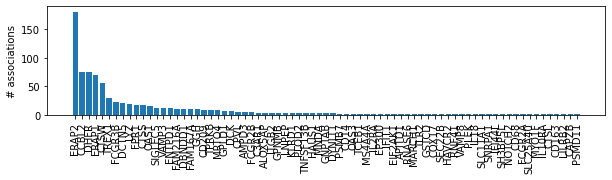

In [20]:
fig = plt.figure(figsize=(10,2))
df_nonhla=nonhla["file"].value_counts().reset_index()
plt.bar(df_nonhla["index"],df_nonhla["file"])
plt.xticks(rotation=90)
plt.ylabel("# associations")
plt.savefig("../plots/fig2/plink.assoc.pdf")

### Get lambda inflation factor

run grep -E "lambda" *log > lambda.txt

In [21]:
pancan=pd.read_csv("../data/plink-associations/associations/lambda.txt",header=None)

In [22]:
pancan["lambda"]=pancan[0].str.split("= ").str[-1]
pancan["lambda"]=pancan["lambda"].str.rstrip(".")
pancan["gene"]=pancan[0].str.split(".").str[0]
pancan["gene"]=pancan["gene"].str.split(".log").str[0]
pancan["lambda"]=pancan["lambda"].astype(float)

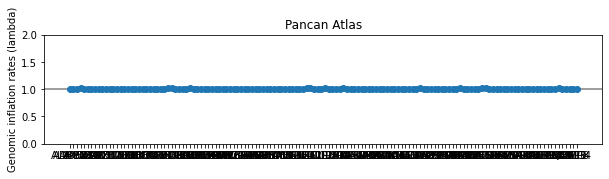

In [23]:
fig = plt.figure(figsize=(10,2))

#plot pancan
plt.errorbar(x=pancan["gene"],y=pancan["lambda"], fmt='o')
plt.ylim(0,2)
plt.axhline(1,color="gray")
plt.ylabel("Genomic inflation rates (lambda)")
plt.title("Pancan Atlas")
plt.savefig("../plots/fig2/lambda.pdf")

### Get HLA associations

In [24]:
hla=extract("../data/conditional-hla/hla_ref/")
hla=hla[hla["p-value"]<(.00001/17)]

17


In [25]:
print("{} associations and {} unique TIME-SNPs from {} IP components".format(len(hla),len(hla["snps"].unique()),len(hla["file"].unique())))

55 associations and 55 unique TIME-SNPs from 17 IP components


In [26]:
ase=extract("../data/conditional-hla/hla_ase/")
ase=ase[ase["p-value"]<(.00001/17)]

8


In [27]:
print("{} associations and {} unique TIME-SNPs from {} IP components".format(len(ase),len(ase["snps"].unique()),len(ase["file"].unique())))

10 associations and 10 unique TIME-SNPs from 6 IP components


In [28]:
hla["type"]="ref"
ase["type"]="ase"

In [29]:
hla=hla.append(ase)

### Get original GWAS

In [30]:
compiled_df=pd.DataFrame()

direct="../data/conditional-hla/hla_ase/"
files=[x for x in os.listdir(direct) if "linear" in x]
files=[x for x in files if ".0." in x]

for x in files:
    df=pd.read_csv(direct+x,delimiter="\t")
    df=df[df["TEST"]=="ADD"]
    df=df[df["P"]<=.00000005]
    compiled_df=compiled_df.append(df)
    
direct="../data/conditional-hla/hla_ref/"
files=[x for x in os.listdir(direct) if "linear" in x]
files=[x for x in files if ".0." in x]

for x in files:
    df=pd.read_csv(direct+x,delimiter="\t")
    df=df[df["TEST"]=="ADD"]
    df=df[df["P"]<=.00000005]
    compiled_df=compiled_df.append(df)

### Make extract file

In [31]:
time_snps=nonhla[["snps","beta","A1","file","p-value"]].append(hla[["snps","beta","file","A1","p-value","type"]])

In [32]:
len(time_snps["file"].unique())

93

## Map MAF

In [34]:
#map to minor allele frequency
maf=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/imputation/michigan-imputation/HRC/european.maf.frq",delim_whitespace=True)
mp_maf=dict(zip(maf["SNP"],maf["MAF"]))
time_snps["maf"]=time_snps["snps"].map(mp_maf)

## Map to RSID

In [35]:
#map to rsid
time_snps['rsid'] = time_snps['snps'].apply(lambda x: map_rsid(x)[1])

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

In [26]:
time_snps[["snps","rsid","maf","file","type","A1","beta","p-value"]].to_csv("../data/supplemental/Supplemental_Table_3.csv",index=None,sep="\t")

### Get literature snps

In [27]:
lit=pd.read_csv("../data/supplemental/Supplemental_Table_5.csv",delimiter="\t")
lit["variant"]=lit["variant"].fillna(lit["rsid"].map({"rs148540887":"4:105606293:TTTTAA:T"}))
lit=lit.rename(columns={"variant":"snps"})
lit["source"]="literature"

In [28]:
time_snps["source"]="discovery"

In [29]:
time_snps_lit=time_snps.append(lit[["snps","rsid","file","beta","p-value","A1","source"]])

In [30]:
print(len(time_snps_lit["snps"].tolist()))
all_snps=[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in time_snps_lit["snps"].tolist()]+time_snps_lit["snps"].tolist()

1084


In [31]:
pd.DataFrame({"snps":all_snps}).to_csv("../snp-tables/extract-all-time-variants.txt",header=None,index=None,sep="\t")

### Export for analysis

In [32]:
len(time_snps_lit["rsid"].tolist())

1084

In [33]:
time_snps_lit["rsid"].to_csv("../snp-tables/extract_all_time_rsid.txt",header=None,index=None,sep="\t")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


### Determine if variant was found

In [34]:
bim=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.bim",header=None,delim_whitespace=True)
bim["snp_noallele"]=bim[1].str.rsplit(":",2).str[0]

In [35]:
time_snps_lit["snp_noallele"]=time_snps_lit["snps"].str.rsplit(":",2).str[0]

In [36]:
time_snps_lit["found"]=np.where(time_snps_lit["snp_noallele"].isin(bim["snp_noallele"].tolist()),"found","not found")

In [37]:
time_snps_lit["found"].value_counts()

found        1025
not found      59
Name: found, dtype: int64

In [38]:
ldlink=pd.read_csv("../data/ldlink/combined_query_snp_list.txt",delimiter="\t")
ldlink["snp_noallele"]=ldlink["Coord"].str.replace("chr","")

mp_proxy={}

for rsid in time_snps_lit[time_snps_lit["found"]=="not found"]["rsid"].unique():
    ldlink_filt=ldlink[ldlink["query_snp"]==rsid].sort_values(by="R2")
    ldlink_filt=ldlink_filt[ldlink_filt["R2"]>0.8]
    ldlink_filt=ldlink_filt[ldlink_filt["snp_noallele"].isin(bim["snp_noallele"].tolist())]
    try:
        mp_proxy[rsid]=ldlink_filt["RS_Number"].tolist()[0]
        print(rsid)
    except:
        print("no proxy for {}".format(rsid))

rs333
no proxy for rs11746140
no proxy for rs698944
no proxy for rs2701005
no proxy for rs17169789
no proxy for rs11995613
no proxy for rs41333046
no proxy for rs1523328
no proxy for rs1385195
no proxy for rs41387649
no proxy for rs4594204
rs35051459
no proxy for rs4764223
no proxy for rs3904452
no proxy for rs6861852
no proxy for rs16991676
no proxy for rs1414646
no proxy for rs17116606
no proxy for rs11984071
no proxy for rs16971480
no proxy for rs12073292
rs7996717
rs9377221
no proxy for rs1704829
no proxy for rs17028564
no proxy for rs12428566
no proxy for rs16932237
rs148540887
rs36084323
rs2227982
no proxy for rs17718883


In [39]:
time_snps_lit["proxy_snp"]=time_snps_lit["rsid"].map(mp_proxy)

In [40]:
ldlink["Alleles"]=ldlink["Alleles"].str.replace(")","")
ldlink["Alleles"]=ldlink["Alleles"].str.replace("(","")

In [41]:
ldlink["variant"]=ldlink["snp_noallele"]+":"+ldlink["Alleles"].str.split("/").str[0]+":"+ldlink["Alleles"].str.split("/").str[1]

In [42]:
mp_proxy_variant=dict(zip(ldlink["RS_Number"],ldlink["variant"]))

In [43]:
time_snps_lit["proxy_variant"]=time_snps_lit["proxy_snp"].map(mp_proxy_variant)

In [44]:
time_snps_lit["proxy_snp"]=time_snps_lit["proxy_snp"].fillna(time_snps_lit["rsid"])
time_snps_lit["proxy_variant"]=time_snps_lit["proxy_variant"].fillna(time_snps_lit["snps"])

In [45]:
time_snps_lit["proxy_snp"].to_csv("../snp-tables/extract_all_time_rsid_proxy.txt",header=None,index=None,sep="\t")

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [46]:
pd.DataFrame(time_snps_lit["proxy_variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in time_snps_lit["proxy_variant"]]).to_csv("../snp-tables/extract-all-time-variants-proxy.txt",header=None,index=None,sep="\t")

In [47]:
time_snps_lit["chr"]=time_snps_lit["proxy_variant"].str.split(":").str[0]

In [48]:
time_snps_lit[["proxy_snp","chr"]].to_csv("../snp-tables/extract_all_time_rsid_ukbb_proxy.txt",header=None,index=None,sep="\t")

## Check for unique number of snps

In [49]:
"{} unique snps out of {} associations".format(len(time_snps_lit["snps"].unique()),len(time_snps_lit))

'1003 unique snps out of 1084 associations'

## Identify cis-trans snps with UCSC Annotation file

### Get annotations

In [50]:
time_snps_lit["file"]=time_snps_lit["file"].replace("PD-1","PDCD1")
time_snps_lit["file"]=time_snps_lit["file"].str.replace(".","-")

In [51]:
ucsc=pd.read_csv("/cellar/users/mpagadal/resources/annotations/ucsc_annot_20191016",delimiter="\t")
print(ucsc.shape)
ucsc.head()

ucsc["cis1"]=ucsc["hg19.knownGene.txStart"]-1000000
ucsc["cis2"]=ucsc["hg19.knownGene.txStart"]+1000000

ucsc.loc[(ucsc['cis1'] < 0), 'cis1'] = 0
ucsc.loc[(ucsc['cis1'] < 0), 'cis2'] = 0

ucsc["hg19.kgXref.geneSymbol"]=ucsc["hg19.kgXref.geneSymbol"].replace("CTSL1","CTSL")

#check if any phenotypes don't have gene location
miss=[]

for x in time_snps_lit["file"].unique():
    x=x.replace(".","-")
    if x not in ucsc["hg19.kgXref.geneSymbol"].tolist():
        miss.append(x)

(82960, 12)


In [52]:
tss=[]

for i,row in time_snps_lit.iterrows():
    c="chr"+row["snps"].split(":")[0]
    b=float(row["snps"].split(":")[1])
    #filter to chromosome
    filt=ucsc[ucsc["hg19.knownGene.chrom"]==c]
    #find difference between 1MB on each side of TSS
    filt["diff1"]=b-filt["cis1"]
    filt["diff2"]=filt["cis2"]-b
    #get cis snps
    filt=filt[(filt["diff1"]>0)&(filt["diff2"]>0)]
    #get gene name
    filt=filt[filt["hg19.kgXref.geneSymbol"]==row["file"]]
    filt["TSS distance"]=filt["hg19.knownGene.txStart"]-b
    lst=filt["TSS distance"].tolist()
    try:
        tss.append(max(set(lst), key = lst.count))
    except:
        tss.append("nan")
        
time_snps_lit["cis tss"]=tss

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


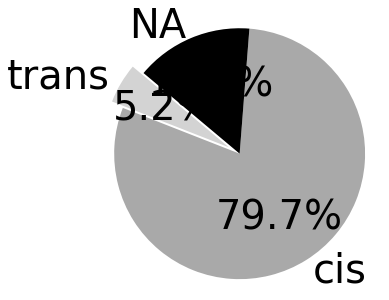

In [53]:
#separate into phenotypes with gene information
na=len(time_snps_lit[time_snps_lit["file"].isin(miss)])/len(time_snps_lit)
nonna=time_snps_lit[~time_snps_lit["file"].isin(miss)]

trans=len(nonna[nonna["cis tss"]=="nan"])/len(time_snps_lit)
cis=len(nonna[nonna["cis tss"]!="nan"])/len(time_snps_lit)

labels = 'trans', 'cis',"NA"
sizes = [trans,cis,na]
colors = ['lightgray', 'darkgray',"black"]
explode = (0.1, 0.0,0)  # explode 1st slice
plt.figure(figsize=(5,5))
mpl.rcParams['font.size'] = 40
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)
 
plt.axis('equal')
plt.savefig("../plots/cis.trans.pdf")

In [54]:
time_snps_lit.to_csv("../data/supplemental/supplemental_table_5.csv",index=None,sep="\t")

### Get VEP assignments

In [10]:
def format4vep(snps,col):
    vep=pd.DataFrame({"snps":snps[col]})
    vep=vep["snps"].str.split(":",expand=True)
    vep[3]=vep[3].astype(str)+"/"+vep[2].astype(str)
    vep[2]=vep[1]
    vep[4]="+"
    vep[5]=snps[col]
    vep[0]=vep[0].replace("X","23")
    vep[0]=pd.to_numeric(vep[0])
    vep[1]=pd.to_numeric(vep[1])
    vep[2]=pd.to_numeric(vep[2])
    
    vep=vep.sort_values(by=[0, 2])
    vep[0]=vep[0].astype(str)
    return(vep)

In [18]:
snps=pd.read_csv("../data/supplemental/Supplemental_Table_3_annot.csv",delimiter="\t")

In [15]:
vep_input=format4vep(snps,"proxy_variant")

In [16]:
vep_input.drop_duplicates().to_csv("../data/vep/vep_all_input.txt",header=None,index=None,sep="\t")

In [23]:
vep_variant=pd.read_csv("../data/vep/wh2MPjXomfK6fQ9R.txt",delimiter="\t")

In [24]:
missense_snps=vep_variant[(vep_variant["Consequence"].str.contains("missense"))]["#Uploaded_variation"].unique().tolist()
TF_snps=vep_variant[vep_variant["Consequence"].str.contains("TF")]["#Uploaded_variation"].unique().tolist()
NMD=vep_variant[vep_variant["Consequence"].str.contains("NMD")]["#Uploaded_variation"].unique().tolist()
noncoding=[x for x in set(vep_variant[vep_variant["Consequence"].str.contains("non_coding")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("prime")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("regulatory")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("intergenic")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("intron")]["#Uploaded_variation"].unique().tolist()+vep_variant[vep_variant["Consequence"].str.contains("stream")]["#Uploaded_variation"].unique().tolist())]
splice=vep_variant[vep_variant["Consequence"].str.contains("splice")]["#Uploaded_variation"].unique().tolist()

In [32]:
snps["missense"]=np.where(snps["snps"].isin(missense_snps),"missense","")
snps["TF"]=np.where(snps["snps"].isin(TF_snps),"TF","")
snps["NMD"]=np.where(snps["snps"].isin(NMD),"NMD","")
snps["splice"]=np.where(snps["snps"].isin(splice),"splice","")

In [35]:
df_gene=vep_variant[["#Uploaded_variation","SYMBOL"]].drop_duplicates()

In [37]:
df_gene=df_gene[df_gene["SYMBOL"]!="-"]

In [41]:
df_gene=df_gene[~df_gene["SYMBOL"].str.startswith("RP")]

In [43]:
df_gene=df_gene.groupby('#Uploaded_variation')['SYMBOL'].apply(lambda x: ','.join(x)).reset_index()

In [45]:
mp_gene=dict(zip(df_gene["#Uploaded_variation"],df_gene["SYMBOL"]))

In [46]:
snps["vep_gene"]=snps["proxy_variant"].map(mp_gene)

In [48]:
snps.to_csv("supp3.tsv")

In [51]:
surv=pd.read_csv("survival-eQTL_all_data.txt",header=None,delimiter="\t")

In [54]:
surv["snp"]=surv[2].str.replace("chr","")+":"+surv[3].astype(str)+":"+surv[4].str.split("/").str[1]+":"+surv[4].str.split("/").str[0]

In [58]:
surv_snps=surv["snp"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+x.split(":")[2] for x in surv["snp"]]

In [62]:
snps[snps["proxy_variant"].isin(surv_snps)]

,A1,beta,file,maf,p-value,rsid,snps,source,type,snp_noallele,...,survival,icb,category,category_clean,risk,missense,TF,NMD,splice,vep_gene
9,A,-0.107875,OAS3,0.3672,4.350000e-10,rs4767037,12:113372804:C:A,discovery,NaN,12:113372804,...,no,no,group1,group1,no,,,,,"OAS3,OAS1"
201,T,-0.175803,ITGB2,0.1735,2.240000e-15,rs760462,21:46328099:C:T,discovery,NaN,21:46328099,...,no,no,group1,group1,no,,TF,NMD,splice,ITGB2


### Get cancer-type specific associations

In [17]:
supp=pd.read_csv("../data/supplemental/Supplemental_Table_3.csv",delimiter="\t")

In [21]:
supp=supp[supp["source"]=="discovery"]

In [22]:
supp["file"]=supp["file"].str.replace("-",".")

In [23]:
supp["assoc"]=supp["snps"]+"_"+supp["file"]

In [24]:
supp

,A1,beta,file,maf,p-value,rsid,snps,source,type,snp_noallele,found,proxy_snp,proxy_variant,chr,cis tss,assoc
0,A,0.280842,HAUS1,0.05038,1.620000e-13,rs72903445,18:43682273:G:A,discovery,NaN,18:43682273,found,rs72903445,18:43682273:G:A,18,2024.0,18:43682273:G:A_HAUS1
1,G,0.301816,HAUS1,0.02610,7.850000e-09,rs12962856,18:43639384:T:G,discovery,NaN,18:43639384,found,rs12962856,18:43639384:T:G,18,44913.0,18:43639384:T:G_HAUS1
2,C,0.092756,HAUS1,0.49010,3.050000e-08,rs12954742,18:43703223:G:C,discovery,NaN,18:43703223,found,rs12954742,18:43703223:G:C,18,-18926.0,18:43703223:G:C_HAUS1
3,C,0.128377,AMPD3,0.45960,1.180000e-14,rs10840420,11:10490415:T:C,discovery,NaN,11:10490415,found,rs10840420,11:10490415:T:C,11,-18192.0,11:10490415:T:C_AMPD3
4,C,-0.123920,AMPD3,0.35570,9.330000e-13,rs7130140,11:10489826:A:C,discovery,NaN,11:10489826,found,rs7130140,11:10489826:A:C,11,-17603.0,11:10489826:A:C_AMPD3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,A,0.096326,HLA.A,0.45460,5.372980e-07,rs1633075,6:29785893:G:A,discovery,ase,6:29785893,found,rs1633075,6:29785893:G:A,6,124353.0,6:29785893:G:A_HLA.A
886,C,0.261701,HLA.DQA1,0.29410,2.299240e-36,rs2395516,6:32580657:T:C,discovery,ase,6:32580657,found,rs2395516,6:32580657:T:C,6,24525.0,6:32580657:T:C_HLA.DQA1
887,G,-0.183482,HLA.DPB1,0.44210,4.143040e-12,rs3130216,6:33077271:A:G,discovery,ase,6:33077271,found,rs3130216,6:33077271:A:G,6,-33569.0,6:33077271:A:G_HLA.DPB1
888,C,-0.281165,HLA.C,0.12860,6.027040e-24,rs2074491,6:31239896:T:C,discovery,ase,6:31239896,found,rs2074491,6:31239896:T:C,6,-3371.0,6:31239896:T:C_HLA.C


In [6]:
assoc_dir="../data/plink-associations/plink_cancer_associations/"
files=[x for x in os.listdir(assoc_dir) if "linear" in x]

compiled_assoc=pd.DataFrame()

for i,x in enumerate(files):
    if i % 100 ==0:
        print(i)
    try:
        assoc=pd.read_csv(assoc_dir+x,delimiter="\t",encoding= 'unicode_escape')
        assoc=assoc[assoc["TEST"]=="ADD"]
        assoc["file"]=x
        compiled_assoc=compiled_assoc.append(assoc)
    except:
        print(x)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [8]:
compiled_assoc["pheno"]=compiled_assoc["file"].str.split(".").str[0]

In [10]:
compiled_assoc["cancer"]=compiled_assoc["pheno"].str.split("_").str[1]
compiled_assoc["pheno"]=compiled_assoc["pheno"].str.split("_").str[0]

In [13]:
compiled_assoc["assoc"]=compiled_assoc["ID"]+"_"+compiled_assoc["pheno"]

In [29]:
compiled_assoc=compiled_assoc[compiled_assoc["assoc"].isin(supp["assoc"].tolist())]

In [36]:
# df_plot=compiled_assoc[["ID","cancer","pheno","BETA"]].drop_duplicates()
df_plot=compiled_assoc.pivot(index="assoc",columns="cancer",values="BETA")

In [37]:
df_plot=df_plot.fillna(0)

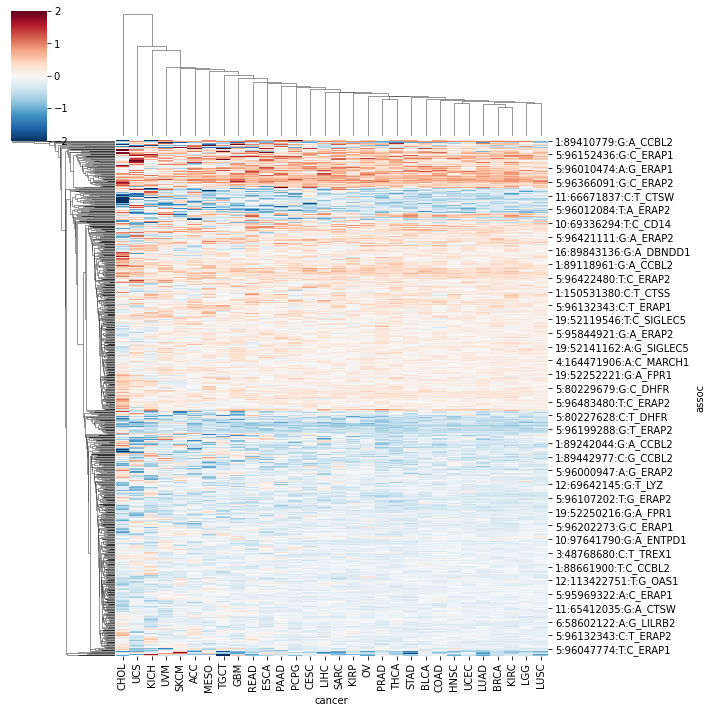

In [42]:
sns.clustermap(df_plot,cmap="RdBu_r",vmin=-2,vmax=2)
plt.savefig("cancer_clustermap.pdf")